In [36]:
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as functional
import torch
!pip install torch-fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64).cuda()

from PIL import Image
from IPython.display import display
import cv2

import random

import os

In [8]:
PATH = '/kaggle/input/celeba-dataset/img_align_celeba'

In [9]:
transform = transforms.Compose([
    #resize the image to 64x64
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [10]:

dataset = datasets.ImageFolder(PATH, transform=transform)


### The Discriminator class

In [16]:
class Generator(nn.Module):
    
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    LATENT_DIM = 100
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            *self.__create_conv_layer(self.LATENT_DIM, 512, kernel_size=4, stride=1, padding=0),
            *self.__create_conv_layer(512, 256),
            *self.__create_conv_layer(256, 128),
            *self.__create_conv_layer(128, 64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=4, stride=2, padding=1) -> list:
        layer = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.ReLU(True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer

    def forward(self, x):
        return self.model(x)
        

        

        

In [20]:
class Discriminator(nn.Module):
    
    LEAKY_RELU_SLOPE = 0.2
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    STARTING_SIZE = 64
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.convolutional_model = nn.Sequential(
            *self.__create_conv_layer(3, 64),
            *self.__create_conv_layer(64, 128),
            *self.__create_conv_layer(128, 256),
            *self.__create_conv_layer(256, 512),
        )
        
        self.flatten_size = self.__get_flatten_size()

        self.fully_connected_model = nn.Sequential(
            *self.__create_fully_connected_layer(self.flatten_size, 512),
            *self.__create_fully_connected_layer(512, 1),
            nn.Sigmoid()
        )
        
    def __get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, self.STARTING_SIZE, self.STARTING_SIZE)
        # Pass the dummy input through the convolutional layers
        dummy_result = self.convolutional_model(dummy_input)
        # Flatten the output to calculate the size
        flatten_size = dummy_result.view(-1).size(0)
        
        return flatten_size

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=3, stride=2, padding=1) -> list:
        layer = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace=True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer
        
    def __create_fully_connected_layer(self, in_features: int, out_features: int) -> list:
        layer = [nn.Linear(in_features, out_features), nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace = True)]
        
        return layer

    def forward(self, x):
        x = self.convolutional_model(x)
        x = x.view(-1, self.flatten_size)
        x = self.fully_connected_model(x)
        
        return x

In [52]:
LEARNING_RATE_GENERATOR = 0.003
LEARNING_RATE_DISCRIMINATOR = 0.001
MOMENTUM_B1 = 0.7
MOMENTUM_B2 = 0.999

loss_function = nn.BCELoss()
generator = Generator().cuda()
discriminator = Discriminator().cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), 
                                       lr=LEARNING_RATE_GENERATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                       )
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                       lr=LEARNING_RATE_DISCRIMINATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                        )



Load the model

In [22]:
# WORKING_PATH = "/kaggle/working/"

# generator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'generator')))
# discriminator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'discriminator')))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/generator'

[Epoch 0/200] [Batch 0/6332] [D loss: 0.046107545495033264] [G loss: 8.191275596618652] [FID: 27.404003143310547]


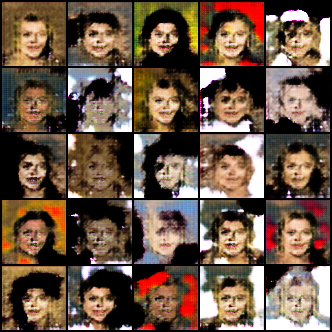

[Epoch 0/200] [Batch 150/6332] [D loss: 0.29874977469444275] [G loss: 23.681957244873047] [FID: 27.260915756225586]


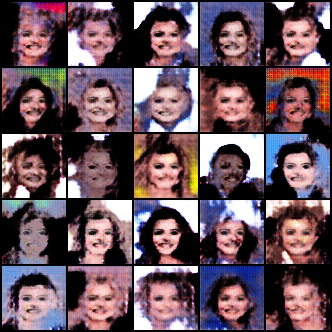

[Epoch 0/200] [Batch 300/6332] [D loss: 0.005059968214482069] [G loss: 7.536962509155273] [FID: 27.117389678955078]


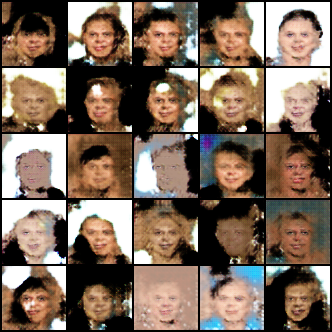

[Epoch 0/200] [Batch 450/6332] [D loss: 0.007231397088617086] [G loss: 10.833578109741211] [FID: 26.964508056640625]


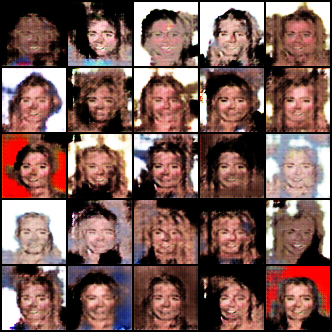

[Epoch 0/200] [Batch 600/6332] [D loss: 0.006947539281100035] [G loss: 10.922445297241211] [FID: 26.801992416381836]


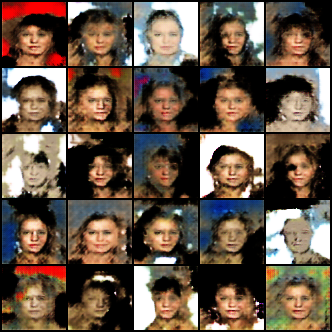

KeyboardInterrupt: 

In [55]:
EPOCHS = 200
K = 3
BATCH_SIZE = 32

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(data_loader):
        
        real_images = real_images.cuda()
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()
        
        for _ in range(K):
            shape = torch.Size((real_images.size(0), Generator.LATENT_DIM, 1, 1))
            noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
            noise = noise.cuda()
            generated_images = generator(noise)
            real_output = discriminator(real_images).cuda()
            fake_output = discriminator(generated_images).cuda()
            
            real_loss = loss_function(real_output, real_labels)
            fake_loss = loss_function(fake_output, fake_labels)
            discriminator_loss = real_loss + fake_loss
            
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
        noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
        noise = noise.cuda()
        generated_images = generator(noise)
        output = discriminator(generated_images)
        
        # We use real_labels because we want to maximize log(D(G(z)))
        # which is equivalent to minimizing log(1-D(G(z)))
        generator_loss = loss_function(output, real_labels)
        
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
        
        if i % 150 == 0:
            generated_images_uint8 = (generated_images.data * 255).clamp(0, 255).byte()
            real_images_uint8 = (real_images.data * 255).clamp(0, 255).byte()
            
            fid.update(generated_images_uint8.data, real=True)
            fid.update(real_images_uint8.data, real=False)
            
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(data_loader)}] [D loss: {discriminator_loss.item()}] [G loss: {generator_loss.item()}] [FID: {fid.compute()}]")

            perm = torch.randperm(generated_images.size(0))
            idx = perm[:25]
            samples = generated_images[idx]
            
            save_image(samples, f"/kaggle/working/{epoch}_{i}.png", nrow=5, normalize=True)
            img = Image.open(f"/kaggle/working/{epoch}_{i}.png")
            display(img)
            
            torch.save(generator.state_dict(), '/kaggle/working/generator')
            torch.save(discriminator.state_dict(), '/kaggle/working/discriminator')

            